In [35]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [46]:
init_X = pd.read_csv('../all_normalized_accuracy_with_pipelineID.csv')

#missing values ratio
print('missing values ratio:', np.sum(np.sum(init_X.isna()).values) / (init_X.shape[0] * init_X.shape[1]))

missing values ratio: 0.20582576929688842


In [44]:
experiment = 'checkpoints'

f = open("../" + experiment + "/results.pkl","rb")
results = pickle.load(f)
f.close()

f = open("../" + experiment + "/X_itFinal.pkl","rb")
X = pickle.load(f)
f.close()

In [36]:
def patch_plot(ax, x, y, yl, yu, label):

    if label.startswith('random'):
        h = ax.plot(x, y, '--', label=label, linewidth=1, alpha=0.6)
    else:
        h = ax.plot(x, y, '-', label=label, linewidth=1)
    ax.fill_between(x, yl, yu, label='', alpha=0.15, facecolor=h[0].get_color())

def plot_comparison(n_evals, regrets, PLOT_TYPE='mean', pct_values=[25,50,75]):

    plt.xlabel('Iterations')
    ax = plt.gca()

    for k in regrets.keys():
        r = regrets[k]
        n_test = r.shape[1]
        if PLOT_TYPE == 'mean':
            regret = r.mean(axis=1)
            regret_sd = r.std(axis=1)
            regret_low = regret - regret_sd/np.sqrt(n_test)
            regret_high = regret + regret_sd/np.sqrt(n_test)
        else:
            pcts = np.percentile(r, pct_values, axis=1)
            regret = pcts[1,:]
            regret_low = pcts[0,:]
            regret_high = pcts[2,:]
        patch_plot(ax, range(n_evals), regret, regret_low, regret_high, label=k)

    plt.legend(loc='upper right')
    if PLOT_TYPE == 'mean':
        plt.ylabel('Regret (mean $\pm$ SE)')
    else:
        plt.ylabel('Regret (quartiles)')

def compare_regrets(regrets):

    n_evals = regrets[list(regrets.keys())[0]].shape[0]
    plot_comparison(n_evals, regrets)
    plt.show()

def compare_ranks(regrets, num_decimals=10):

    all_results = np.stack([regrets[k] for k in regrets.keys()], axis=2)
    all_results = np.around(all_results, num_decimals)
    ranks0 = np.apply_along_axis(st.rankdata, 2, all_results)
    ranks = {}
    for i in range(len(regrets.keys())):
        ranks[list(regrets.keys())[i]] = ranks0[:,:,i].squeeze()

    n_evals = regrets[list(regrets.keys())[0]].shape[0]
    plot_comparison(n_evals, ranks)
    plt.ylabel('Rank (mean $\pm$ SE)')
    plt.show()

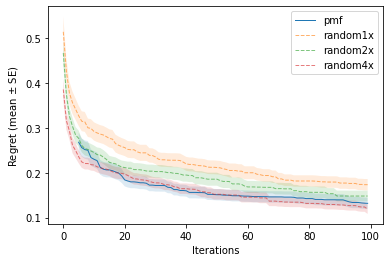

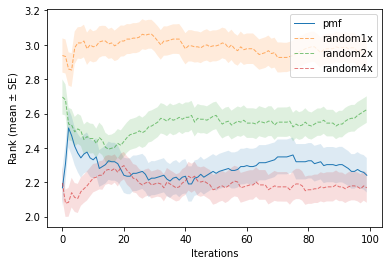

In [45]:
compare_regrets(results);
compare_ranks(results);